# Starbucks Capstone Challenge

### Table of Contents

I. [Introduction](#intro)<br>
II. [Data](#data)<br>
&nbsp;&nbsp; a. [Cleaning](#clean)<br>
III. [Exploratory Analysis](#explore)<br>
&nbsp;&nbsp; a. [Descriptive Statistics Summary](#describe)<br>
IV. [Machine Learning](#learn)<br>
V. [Conclusion](#conclude)<br>


<a id='intro'></a>
## I. Introduction

The dataset contains simulated data for customer behavior in the Starbucks rewards app. The goal of this project is to combine transaction, demographic, and offer data to determine which groups respond best to a particular offer. 

One thing to note is that a customer may fulfill an offer without ever viewing it. For example, an offer may be available that gives a 2 dollar off bonus if 10 dollars or more is spent. The customer may qualify for the offer without ever seeing it. Therefore, their behavior was not impacted by the offer. This must be taken into consideration because we do not necessarily want to send this offer to someone who is going to spend the 10 dollars anyways. The goal of the offers is to increase purchasing, not necessarily to reward users.


<a id='data'></a>
## II. Data

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [2]:
# imports

import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sb

from datetime import datetime

import re
import os

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

print("Imports successful.")

Imports successful.


In [24]:
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [4]:
# PORTFOLIO 

portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [5]:
# PROFILE

profile.shape

(17000, 5)

In [25]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [8]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a19c0ca90>,
      dtype=object)

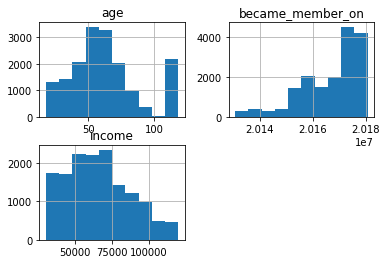

In [9]:
profile.hist()

In [10]:
# TRANSCRIPT 

transcript.shape

(306534, 4)

In [11]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [12]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

<a id='clean'></a>
## Cleaning

**Portfolio**

- {x} Divide the channels column into web, email, mobile, and social
- {x} Rename id to offer_id
    - {x} Map new offer ids to be smaller strings:
        - I1-I2: informational
        - D1-D4: discount
        - B1-B4: BOGO
- {x} Drop offer type column as this data is encapsulated in the code name


In [5]:
def clean_portfolio_df(df):
    """
    Cleans the portfolio dataframe 
    - divide channels into web, email, mobile, and social
    - divide offer_type into columns
    - rename id to offer_id
    
    Input: df - original unclean dataframe
    Output: portfolio_clean - cleaned portfolio dataframe
    """
    portfolio_clean = df.copy()
    
    # divide channels column
    
    channel_names = pd.get_dummies(portfolio_clean.channels.apply(pd.Series).stack(), prefix='channel').sum(level=0)
    portfolio_clean = pd.concat([portfolio_clean, channel_names], axis=1, sort=False)

    # rename id to offer_id
    portfolio_clean.rename(columns={'channel_email':'email',
                                   'channel_mobile':'mobile',
                                   'channel_social':'social',
                                   'channel_web':'web'}, inplace=True)
    
    # replace specific offer_ids with shorter codes
    di = {'ae264e3637204a6fb9bb56bc8210ddfd':'B1',
         '4d5c57ea9a6940dd891ad53e9dbe8da0': 'B2',
         '3f207df678b143eea3cee63160fa8bed':'I1',
         '9b98b8c7a33c4b65b9aebfe6a799e6d9':'B3',
         '0b1e1539f2cc45b7b9fa7c272da2e1d7':'D1',
         '2298d6c36e964ae4a3e7e9706d1fb8c2':'D2',
         'fafdcd668e3743c1bb461111dcafc2a4':'D3',
         '5a8bc65990b245e5a138643cd4eb9837':'I2',
         'f19421c1d4aa40978ebb69ca19b0e20d':'B4',
         '2906b810c7d4411798c6938adc9daaa5':'D4'}
    
    portfolio_clean['offer_id'] = portfolio_clean['id']
    portfolio_clean['offer_id'].replace(di, inplace=True)
    
    portfolio_clean.drop(columns=['offer_type','channels', 'offer_type', 'id'], inplace=True)
    
    return portfolio_clean
    

In [6]:
portfolio_clean = clean_portfolio_df(portfolio)

portfolio_clean

,reward,difficulty,duration,email,mobile,social,web,offer_id
0,10,10,7,1,1,1,0,B1
1,10,10,5,1,1,1,1,B2
2,0,0,4,1,1,0,1,I1
3,5,5,7,1,1,0,1,B3
4,5,20,10,1,0,0,1,D1
5,3,7,7,1,1,1,1,D2
6,2,10,10,1,1,1,1,D3
7,0,0,3,1,1,1,0,I2
8,5,5,5,1,1,1,1,B4
9,2,10,7,1,1,0,1,D4


In [133]:
portfolio_clean.describe()

,reward,difficulty,duration,email,mobile,social,web
count,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000,1.0,0.900000,0.600000,0.800000
std,3.583915,5.831905,2.321398,0.0,0.316228,0.516398,0.421637
min,0.000000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000
25%,2.000000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000
50%,4.000000,8.500000,7.000000,1.0,1.000000,1.000000,1.000000
75%,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000
max,10.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000


**Profile**

- {x} Ensure all age and income data is valid
    - {x} Replace rows where age = 118 with NaN
- {x} Create columns for year when member joined
- {x} Rename id to member_id
- {x} Create separate columns for gender


In [7]:
def convert_to_datetime(elem):
    return datetime.strptime(str(elem), '%Y%m%d')

def clean_profile_df(df):
    """ 
    Cleans the profile dataframe
    - replace ages of 118 with NaN
    - create columns for year of membership start
    - rename id to member_id
    - create separate columns for gender
    
    Input: df - original unclean dataframe
    Output: profile_clean - cleaned profile dataframe
    """
    profile_clean = df.copy()
    
    # replace incorrect age with NaN
    profile_clean.age = profile.age.apply(lambda x: np.nan if x == 118 else x)
    
    # create columns for membership start
    profile_clean.became_member_on = profile_clean.became_member_on.apply(convert_to_datetime)
    profile_clean['startyear'] = profile_clean.became_member_on.apply(lambda elem: elem.year)
    profile_clean['startmonth'] = profile_clean.became_member_on.apply(lambda elem: elem.month)
    
    # rename id to member_id
    profile_clean.rename(columns={'id':'member_id'}, inplace=True)
    
    # create columns for gender
    genders = pd.get_dummies(profile_clean.gender)
    profile_clean = pd.concat([profile_clean, genders], axis=1, sort=False)
    
    profile_clean.drop(columns=['gender', 'became_member_on'], inplace=True)
    
    return profile_clean

In [8]:
profile_clean = clean_profile_df(profile)

profile_clean.head()

,age,member_id,income,startyear,startmonth,F,M,O
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,0,0,0
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,1,0,0
2,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,0,0,0
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,1,0,0
4,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,0,0,0


In [62]:
profile_clean.describe()

,age,income,startyear,startmonth,F,M,O
count,14825.000000,14825.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,54.393524,65404.991568,2016.635000,6.683529,0.360529,0.499059,0.012471
std,17.383705,21598.299410,1.177624,3.487098,0.480168,0.500014,0.110977
min,18.000000,30000.000000,2013.000000,1.000000,0.000000,0.000000,0.000000
25%,42.000000,49000.000000,2016.000000,4.000000,0.000000,0.000000,0.000000
50%,55.000000,64000.000000,2017.000000,7.000000,0.000000,0.000000,0.000000
75%,66.000000,80000.000000,2017.000000,10.000000,1.000000,1.000000,0.000000
max,101.000000,120000.000000,2018.000000,12.000000,1.000000,1.000000,1.000000


**Transcript**

- {x} Rename person to member_id
- {x} Create a separate offer dataframe that only contains offers
    - {x} Map offer_id as described previously
- {x} Create a separate transaction dataframe
    - {x} Remove transactions that are over 50 dollars

In [9]:
def clean_transcript_df(df):
    """ 
    Cleans the transcript dataframe
    - rename person as member_id
    - separate the dataframe into offers and transaction
    - transaction over 50 dollars will be removed

    Input: df - original unclean dataframe
    Output: transcript_clean - cleaned transcript dataframe
            offers_df - cleaned offer dataframe
            transaction_df - cleaned transaction dataframe
    """
    transcript_clean = df.copy()
    
    # rename person as member_id
    transcript_clean.rename(columns={'person':'member_id'}, inplace=True)
    
    # create offers dataframe
    offers_df = transcript_clean[transcript_clean['event'].str.contains('offer')]
    offers_df['offer_id'] = [[*v.values()][0]
                                    if [*v.keys()][0] in ['offer id',
                                                          'offer_id'] else None
                                    for v in offers_df.value]
    # remap offer_id with shorter string codes
    di = {'ae264e3637204a6fb9bb56bc8210ddfd':'B1',
         '4d5c57ea9a6940dd891ad53e9dbe8da0': 'B2',
         '3f207df678b143eea3cee63160fa8bed':'I1',
         '9b98b8c7a33c4b65b9aebfe6a799e6d9':'B3',
         '0b1e1539f2cc45b7b9fa7c272da2e1d7':'D1',
         '2298d6c36e964ae4a3e7e9706d1fb8c2':'D2',
         'fafdcd668e3743c1bb461111dcafc2a4':'D3',
         '5a8bc65990b245e5a138643cd4eb9837':'I2',
         'f19421c1d4aa40978ebb69ca19b0e20d':'B4',
         '2906b810c7d4411798c6938adc9daaa5':'D4'}

    offers_df['offer_id'].replace(di, inplace=True)
    
    offers_df.drop(columns=['value'], inplace=True)
    
    # create transaction dataframe
    transaction_df = transcript_clean[transcript_clean['event'].str.contains('transaction')]
    transaction_df['amount'] = [np.round([*v.values()][0], decimals=2)
                                  if [*v.keys()][0] == 'amount' else None
                                  for v in transaction_df.value]
    transaction_df.drop(columns=['value'], inplace=True)
    
    transaction_df = transaction_df[transaction_df['amount'] <= 50]
    
    return transcript_clean, offers_df, transaction_df



In [10]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [11]:
transcript_clean, offers_df, transaction_df = clean_transcript_df(transcript)

offers_df.head(5)

,member_id,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,B3
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,D1
2,e2127556f4f64592b11af22de27a7932,offer received,0,D4
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,D3
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,B2


In [66]:
transaction_df.head(5)

,member_id,event,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97


In [67]:
transaction_df.describe()

,time,amount
count,138247.000000,138247.000000
mean,381.524474,11.223732
std,201.680127,9.609878
min,0.000000,0.050000
25%,210.000000,2.760000
50%,402.000000,8.800000
75%,552.000000,17.910000
max,714.000000,49.940000


### Merging Data

In [68]:
# merging profile and offers

profile_offers = pd.merge(profile_clean, offers_df, on='member_id')
profile_offers = pd.merge(profile_offers, portfolio_clean, on='offer_id')
profile_offers.head()

,age,member_id,income,startyear,startmonth,F,M,O,event,time,offer_id,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,0,0,0,offer received,168,D4,2,10,7,1,1,0,1,0,1,0
1,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,0,0,0,offer viewed,216,D4,2,10,7,1,1,0,1,0,1,0
2,68.0,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,0,1,0,offer received,0,D4,2,10,7,1,1,0,1,0,1,0
3,68.0,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,0,1,0,offer viewed,18,D4,2,10,7,1,1,0,1,0,1,0
4,NaN,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,2017,9,0,0,0,offer received,408,D4,2,10,7,1,1,0,1,0,1,0


In [24]:
# merging profile and transactions

profile_transactions = pd.merge(profile_clean, transaction_df, on='member_id')
profile_transactions.head()

,age,member_id,income,startyear,startmonth,F,M,O,event,time,amount
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,0,0,0,transaction,360,0.35
1,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,0,0,0,transaction,414,0.74
2,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,0,0,0,transaction,444,1.89
3,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,0,0,0,transaction,510,5.04
4,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,0,0,0,transaction,534,0.38


In [69]:
# complete merge of all datasets

def drop_y(df):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)

df_complete = pd.merge(profile_offers, profile_transactions, on='member_id', suffixes=('', '_y'))
drop_y(df_complete)

df_complete.head()

,age,member_id,income,startyear,startmonth,F,M,O,event,time,offer_id,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,amount
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,0,0,0,offer received,168,D4,2,10,7,1,1,0,1,0,1,0,0.35
1,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,0,0,0,offer received,168,D4,2,10,7,1,1,0,1,0,1,0,0.74
2,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,0,0,0,offer received,168,D4,2,10,7,1,1,0,1,0,1,0,1.89
3,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,0,0,0,offer received,168,D4,2,10,7,1,1,0,1,0,1,0,5.04
4,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,0,0,0,offer received,168,D4,2,10,7,1,1,0,1,0,1,0,0.38


In [70]:
df_complete.event.value_counts()

offer received     635198
offer viewed       491053
offer completed    331820
Name: event, dtype: int64

In [71]:
df_complete.describe()

,age,income,startyear,startmonth,F,M,O,time,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,amount
count,1.321632e+06,1.321632e+06,1.458071e+06,1.458071e+06,1.458071e+06,1.458071e+06,1.458071e+06,1.458071e+06,1.458071e+06,1.458071e+06,1.458071e+06,1458071.0,1.458071e+06,1.458071e+06,1.458071e+06,1.458071e+06,1.458071e+06,1.458071e+06,1.458071e+06
mean,5.303716e+01,6.269124e+04,2.016316e+03,6.725437e+00,3.739825e-01,5.189692e-01,1.347328e-02,3.525864e+02,4.458224e+00,7.922947e+00,6.676598e+00,1.0,9.223522e-01,6.732601e-01,8.088955e-01,4.289723e-01,4.283715e-01,1.426563e-01,1.202805e+01
std,1.775741e+01,2.067782e+04,1.197559e+00,3.511045e+00,4.838592e-01,4.996402e-01,1.152899e-01,1.985797e+02,3.359067e+00,4.908405e+00,2.126334e+00,0.0,2.676166e-01,4.690214e-01,3.931713e-01,4.949295e-01,4.948429e-01,3.497221e-01,9.630581e+00
min,1.800000e+01,3.000000e+04,2.013000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-02
25%,4.000000e+01,4.700000e+04,2.016000e+03,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.680000e+02,2.000000e+00,5.000000e+00,5.000000e+00,1.0,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.300000e+00
50%,5.400000e+01,6.100000e+04,2.017000e+03,7.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,4.080000e+02,5.000000e+00,1.000000e+01,7.000000e+00,1.0,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.040000e+01
75%,6.600000e+01,7.400000e+04,2.017000e+03,1.000000e+01,1.000000e+00,1.000000e+00,0.000000e+00,5.100000e+02,5.000000e+00,1.000000e+01,7.000000e+00,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.875000e+01
max,1.010000e+02,1.200000e+05,2.018000e+03,1.200000e+01,1.000000e+00,1.000000e+00,1.000000e+00,7.140000e+02,1.000000e+01,2.000000e+01,1.000000e+01,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.994000e+01


<a id='explore'></a>
## III. Exploratory Analysis

First, we will perform some exploratory analysis. This will help inform our research questions and help us design a machine learning model.

### User Histograms

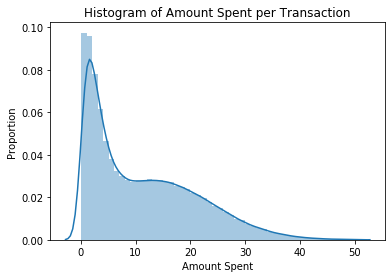

In [258]:
# histogram of transaction amount

sb.distplot(transaction_df.amount)
plt.xlabel("Amount Spent")
plt.ylabel("Proportion")
plt.title("Histogram of Amount Spent per Transaction");

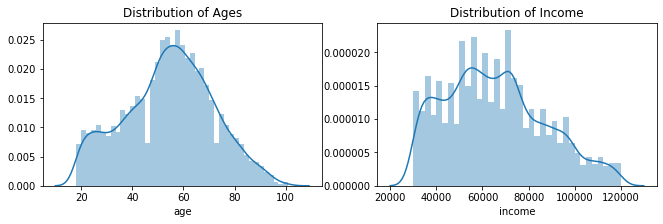

In [73]:
# histograms of members data

def members_plot(x, t): # x is the variables of interest, t is the titles
    title_index = 0
    for var in x:
        plt.subplot(1,2,title_index+1)
        ax = sb.distplot(profile_clean[var])
        plt.xlabel(var)
        plt.title(t[title_index])
        title_index += 1
        
        
f, axs = plt.subplots(1,2,figsize=(11,3))        
x_vars = ['age', 'income']
titles = ['Distribution of Ages', 'Distribution of Income']

members_plot(x_vars, titles)

### Gender Analysis

In [74]:
# transactions by gender

gender_transactions = profile_transactions.groupby(['F','M']).mean()
gender_transactions

age        income    startyear  startmonth         O        time  \
F M                                                                           
0 0  52.892334  61034.949267  2016.502933    6.595475  0.106189  383.064767   
  1  50.721658  58477.689854  2016.245460    6.654528  0.000000  381.678336   
1 0  55.637004  66796.722980  2016.410523    6.835416  0.000000  380.773947   

        amount  
F M             
0 0   3.572512  
  1  10.100174  
1 0  15.481402

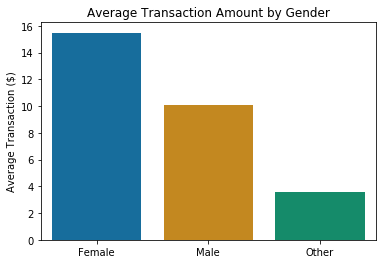

In [259]:
genders = ['Female', 'Male', 'Other']
gender_mean_trans = [15.48, 10.10, 3.57]

sb.barplot(x=genders, y=gender_mean_trans, palette='colorblind')
plt.title('Average Transaction Amount by Gender')
plt.ylabel('Average Transaction ($)');

So far, we know that females spend more across all transaction. Lets look only at transactions wherein an offer was completed.

In [76]:
completed_offer = df_complete[df_complete.event == 'offer completed']

gender_completed_offer = completed_offer.groupby(['F','M']).mean()
gender_completed_offer

age        income    startyear  startmonth        O        time  \
F M                                                                          
0 0  54.285964  62409.823335  2016.347053    6.704693  0.30637  414.866472   
  1  51.950198  61909.503273  2016.171416    6.720736  0.00000  396.619834   
1 0  56.123325  68710.495605  2016.369297    6.867249  0.00000  387.315490   

       reward  difficulty  duration  email    mobile    social       web  \
F M                                                                        
0 0  3.996312    8.567537  7.555047    1.0  0.940046  0.708916  0.944983   
  1  4.694919    9.165881  7.386265    1.0  0.906548  0.667938  0.900232   
1 0  5.047075    9.363123  7.308128    1.0  0.894982  0.653008  0.880404   

         bogo  discount  informational     amount  
F M                                                
0 0  0.378219  0.621781            0.0   6.527638  
  1  0.437736  0.562264            0.0  12.909763  
1 0  0.478942  0.521058            0.0  16.893436

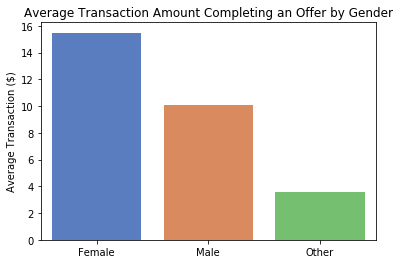

In [77]:
gender_mean_trans_offer = [16.89, 12.91, 6.53]

sb.barplot(x=genders, y=gender_mean_trans, palette='muted')
plt.title('Average Transaction Amount Completing an Offer by Gender')
plt.ylabel('Average Transaction ($)');

We see the same trend in spending where females spend more than males. Interestingly, though, all spending increased when offers were being completed. 

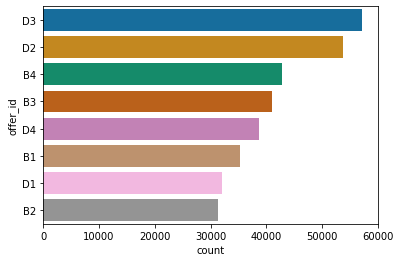

In [80]:
# determine which offers were completed most often
# informational offers cannot be completed

sb.countplot(y=completed_offer['offer_id'], order=completed_offer['offer_id'].value_counts().index ,palette='colorblind');

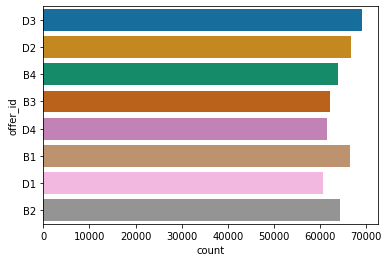

In [81]:
# determine which offers were received most often
# order identical as order above

sb.countplot(y=df_complete[df_complete.event == 'offer received']['offer_id'], order=completed_offer['offer_id'].value_counts().index, palette='colorblind');

In [97]:
offers_df.head()

,member_id,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,B3
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,D1
2,e2127556f4f64592b11af22de27a7932,offer received,0,D4
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,D3
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,B2


In [12]:
def calculate_offer_rates(df):
    states = ['offer received', 'offer viewed', 'offer completed']
    names = ['received_count', 'viewed_count', 'completed_count']
    offer_rates = pd.DataFrame(columns=['offer_id'])
    for i in range(len(states)):
        df1 = df[df['event'] == states[i]]
        df1count = df1[['offer_id', 'event']].groupby('offer_id').count().reset_index()
        df1count.rename(columns={'event':names[i]}, inplace=True)
        offer_rates = pd.merge(offer_rates, df1count, how='outer')
    
    for row in offer_rates:
        offer_rates['receive_to_view'] = offer_rates.viewed_count / offer_rates.received_count
        offer_rates['view_to_complete'] = offer_rates.completed_count / offer_rates.viewed_count
        offer_rates['recieve_to_complete'] = offer_rates.completed_count / offer_rates.received_count
        
    return offer_rates

offer_rates = calculate_offer_rates(offers_df)
offer_rates

# this data has a few anomalies in view_to_complete because users
# can complete an offer without having viewed it

,offer_id,received_count,viewed_count,completed_count,receive_to_view,view_to_complete,recieve_to_complete
0,B1,7658,6716,3688.0,0.876991,0.549136,0.481588
1,B2,7593,7298,3331.0,0.961148,0.456426,0.438694
2,B3,7677,4171,4354.0,0.543311,1.043874,0.567149
3,B4,7571,7264,4296.0,0.959451,0.591410,0.567428
4,D1,7668,2663,3420.0,0.347287,1.284266,0.446009
5,D2,7646,7337,5156.0,0.959587,0.702740,0.674340
6,D3,7597,7327,5317.0,0.964460,0.725672,0.699882
7,D4,7632,4118,4017.0,0.539570,0.975474,0.526336
8,I1,7617,4144,NaN,0.544046,NaN,NaN
9,I2,7618,6687,NaN,0.877789,NaN,NaN


In [13]:
# determine if a user successfully completed an offer

def combine_data(profile, portfolio, offers_df, transaction_df):
    data = []
    customer_ids = offers_df['member_id'].unique()
    
    # loop through all customers
    for ind in range(len(customer_ids)):
        
        cust_id = customer_ids[ind]
        cust = profile[profile['member_id']==cust_id]
        
        customer = cust
        customer_offer = cust_offers
        cust_transcation_data = cust_trans

        cust_offers = offers_df[offers_df['member_id']==cust_id]
        cust_trans = transaction_df[transaction_df['member_id']==cust_id]
        
        # extract received, completed, viewed offer data from customer offers
        offer_received_data = cust_offers[cust_offers['offer_received'] == 1]
        offer_completed_data = cust_offers[cust_offers['offer_completed'] == 1]
        offer_viewed_data = cust_offers[cust_offers['offer_viewed'] == 1]
        
        rows = []
        # loop through each received offer
        for i in range(offer_received_data.shape[0]):
            
            offer_id = offer_received_data.iloc[i]['offer_id']
            offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
            
            # how long an offer is valid
            duration_days = offer_row['duration'].values[0]
            
            # start and end time of an offer
            start_time = offer_received_data.iloc[i]['time']
            end_time = start_time + duration_days
        
            # offers that were completed before they expired
            off_completed_withintime = np.logical_and(
                offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)
            
            # offers that were viewed before they expired
            off_viewed_withintime = np.logical_and(
                offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)

            # if offer was both viewed and completed before it expired, it was successful (1)
            offer_successful = off_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0
            
            # transactions before offer expiry
            transaction_withintime = np.logical_and(
                cust_transaction_data['time'] >= start_time, cust_transaction_data['time'] <= end_time)
        
            transaction_data = cust_transaction_data[transaction_withintime]
            
            # how much a user spends based on offers
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'member_id': member_id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
                
            row.update(offer_row.iloc[0,0:].to_dict())

            row.update(customer.iloc[0,:].to_dict())

            rows.append(row)
        
        data.extend(rows)
    
    data = pd.DataFrame(data)
    return data


# combined_data = combine_data(profile_clean, portfolio_clean, offers_df, transaction_df)

# this program takes a long time to run, so data was exported as a csv and can 
# be reimported with the following line: 

combined_data = pd.read_csv("combined_data.csv")

In [14]:
combined_data.head()

,offer_id,customer_id,time,total_amount,offer_successful,reward,difficulty,duration,web,email,social,mobile,bogo,informational,discount,gender,age,became_member_on,income,start_year,start_month
0,B3,78afa995795e4d85b5d9ceeca43f5fef,0.0,37.67,1,5,5,7,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,75.0,2017-05-09,100000.0,2017,5
1,I2,78afa995795e4d85b5d9ceeca43f5fef,7.0,49.39,0,0,0,3,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0,75.0,2017-05-09,100000.0,2017,5
2,B1,78afa995795e4d85b5d9ceeca43f5fef,17.0,48.28,1,10,10,7,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0,75.0,2017-05-09,100000.0,2017,5
3,B4,78afa995795e4d85b5d9ceeca43f5fef,21.0,48.28,1,5,5,5,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,75.0,2017-05-09,100000.0,2017,5
4,D4,e2127556f4f64592b11af22de27a7932,0.0,0.00,0,2,10,7,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,68.0,2018-04-26,70000.0,2018,4


In [151]:
combined_data.shape

(66501, 21)

In [15]:
# percent success of an offer assuming that the member viewed the offer

def percent_success_true():
    success = combined_data[['offer_id', 'offer_successful']].groupby('offer_id').sum().reset_index()
   
    # create a dataframe of offer counts
    offers_count = combined_data['offer_id'].value_counts()
    offers_count = pd.DataFrame(list(zip(offers_count.index.values, offers_count.values)), columns = ['offer_id', 'count'])
   
    # sort by offer_id for easy comparison
    success = success.sort_values('offer_id')
    offers_count = offers_count.sort_values('offer_id')

    
    # calculate percent success per offer
    per_success = pd.merge(offers_count, success, on='offer_id')
    per_success['percent_success'] = (100 * per_success['offer_successful']/per_success['count'])
    
    # merge with portfolio and drop intermediate columns
    per_success = pd.merge(per_success, portfolio_clean, on='offer_id')
    per_success = per_success.drop(columns=['offer_successful'])
    
    # sort
    per_success = per_success.sort_values('percent_success', ascending=False)
    
    portfolio_percents = per_success.reset_index(drop=True)
    
    return per_success

portfolio_full = percent_success_true()
portfolio_full
    

,offer_id,count,percent_success,reward,difficulty,duration,email,mobile,social,web
6,D3,6652,75.285628,2,10,10,1,1,1,1
5,D2,6655,72.742299,3,7,7,1,1,1,1
3,B4,6576,61.618005,5,5,5,1,1,1,1
0,B1,6683,54.646117,10,10,7,1,1,1,0
1,B2,6593,51.721523,10,10,5,1,1,1,1
2,B3,6685,48.287210,5,5,7,1,1,0,1
7,D4,6631,47.730357,2,10,7,1,1,0,1
4,D1,6726,45.762712,5,20,10,1,0,0,1
8,I1,6657,7.721196,0,0,4,1,1,0,1
9,I2,6643,6.277284,0,0,3,1,1,1,0


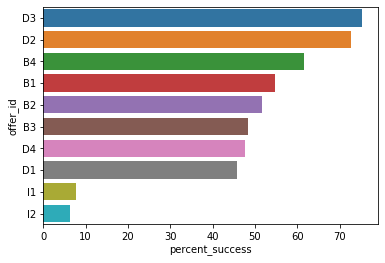

In [16]:
sb.barplot(x=portfolio_full['percent_success'], y=portfolio_full['offer_id'], data=portfolio_full);

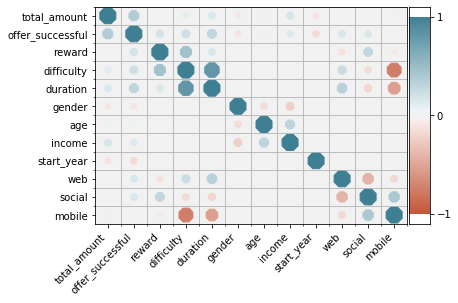

In [17]:
# ref: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

from heatmap import heatmap, corrplot

columns = ['total_amount', 'offer_successful', 'reward', 'difficulty', 'duration', 'gender', 'age', 'income', 'start_year', 'web', 'social', 'mobile']
corr = combined_data[columns].corr()

corrplot(corr, size_scale=300, marker='8')


<a id='describe'></a>
### Descriptive Statistics Summary


- Females spend more than any other gender, especially after receiving an offer.
- Most transactions are under 8 dollars.
- The most successful offers are the 2 dollar discount after spending 10 dollars and the 3 dollar discount after spending 7 dollars. The least successful reward is the 5 dollar discount after spending 20 dollars. 
- There were two offers for 2 dollars off after spending 10 dollars. One was the most successful and the other was second to last in success (not including informational offers). The successful one ran for 10 days while the unsuccessful one ran for 7 days.
- The most successful offers were ran on all platforms and the least successful ones were not ran on social media. 
- From the correlation plot, if we consider the offer_successful row, we see that nothing has a particularly strong correlation with whether an offer will be successful. Likely, it is a combination of factors that make an offer successful. Therefore, this problem requires machine learning. 



<a id='learn'></a>
## IV. Machine Learning

In order to help predict what will make an offer successful, we will run a machine learning algorithm.


In [38]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
import eli5
from eli5.sklearn import PermutationImportance
print("Imports successful.")

Imports successful.


In [33]:
combined_data.head()

,offer_id,customer_id,time,total_amount,offer_successful,reward,difficulty,duration,web,email,social,mobile,bogo,informational,discount,gender,age,became_member_on,income,start_year,start_month
0,B3,78afa995795e4d85b5d9ceeca43f5fef,0.0,37.67,1,5,5,7,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,75.0,2017-05-09,100000.0,2017,5
1,I2,78afa995795e4d85b5d9ceeca43f5fef,7.0,49.39,0,0,0,3,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0,75.0,2017-05-09,100000.0,2017,5
2,B1,78afa995795e4d85b5d9ceeca43f5fef,17.0,48.28,1,10,10,7,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0,75.0,2017-05-09,100000.0,2017,5
3,B4,78afa995795e4d85b5d9ceeca43f5fef,21.0,48.28,1,5,5,5,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,75.0,2017-05-09,100000.0,2017,5
4,D4,e2127556f4f64592b11af22de27a7932,0.0,0.00,0,2,10,7,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,68.0,2018-04-26,70000.0,2018,4


In [34]:
features = combined_data.drop(columns=['offer_successful', 'offer_id', 'customer_id', 'became_member_on'])
label = combined_data.filter(['offer_successful'])

x_train, x_test, y_train, y_test = train_test_split(features.values, label.values, test_size = 0.25, random_state=13)

In [262]:
features.head(4)

,time,total_amount,reward,difficulty,duration,web,email,social,mobile,bogo,informational,discount,gender,age,income,start_year,start_month
0,0.0,37.67,5,5,7,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,75.0,100000.0,2017,5
1,7.0,49.39,0,0,3,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0,75.0,100000.0,2017,5
2,17.0,48.28,10,10,7,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0,75.0,100000.0,2017,5
3,21.0,48.28,5,5,5,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,75.0,100000.0,2017,5


In [53]:
# model scorer
def model_score(model):
    pred = model.predict(x_test)
    
    # Calculate the absolute errors
    errors = abs(pred - y_test)
    
    # Calculate mean absolute percentage error
    meanpred = 100 * (errors / y_test)
    accuracy = 100 - np.mean(meanpred)
    
    return round(accuracy, 4)

### Decision Tree Classifier and Logistic Regression

In [47]:
dt = DecisionTreeClassifier()
lr = LogisticRegression()

In [48]:
dt.fit(x_train, y_train)
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
dt_pred_train = dt.predict(x_train)
lr_pred_train = lr.predict(x_train)

dt_pred_test = dt.predict(x_test)
lr_pred_test = lr.predict(x_test)

In [50]:
dt_prob = dt.predict_proba(x_test)[:,1]
lr_prob = lr.predict_proba(x_test)[:,1]

In [248]:
print(classification_report(y_test,dt_pred_test))
print('Decision Tree: ' + str(roc_auc_score(y_test, dt_pred_test)))

print(classification_report(y_test,lr_pred_test))
print('Logistic Regression: ' + str(roc_auc_score(y_test, lr_pred_test)))

# where 0 is unsuccessful offer and 1 is successful offer

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      8723
           1       0.87      0.86      0.87      7903

    accuracy                           0.87     16626
   macro avg       0.87      0.87      0.87     16626
weighted avg       0.87      0.87      0.87     16626

Decision Tree: 0.8727820046192608
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      8723
           1       0.85      0.72      0.78      7903

    accuracy                           0.81     16626
   macro avg       0.82      0.80      0.81     16626
weighted avg       0.81      0.81      0.81     16626

Logistic Regression: 0.8044773113018622


In [252]:
perm = PermutationImportance(lr, random_state=1).fit(x_train, y_train)
eli5.show_weights(perm, feature_names = features.columns.tolist())

Weight,Feature
0.2902 ± 0.0028,total_amount
0.0069 ± 0.0011,reward
0.0025 ± 0.0010,duration
0.0011 ± 0.0018,difficulty
0.0011 ± 0.0004,age
0.0008 ± 0.0004,social
0.0008 ± 0.0002,informational
0.0003 ± 0.0001,bogo
0.0003 ± 0.0001,web
0.0003 ± 0.0001,mobile


In [263]:
perm = PermutationImportance(dt, random_state=1).fit(x_train, y_train)
eli5.show_weights(perm, feature_names = features.columns.tolist())

Weight,Feature
0.4076 ± 0.0053,total_amount
0.1335 ± 0.0012,duration
0.0845 ± 0.0016,income
0.0684 ± 0.0017,age
0.0637 ± 0.0017,time
0.0551 ± 0.0017,social
0.0455 ± 0.0015,start_year
0.0407 ± 0.0009,start_month
0.0380 ± 0.0013,reward
0.0192 ± 0.0007,gender


As probably expected, the amount of the award has the greatest impact on whether it will be fulfilled. Income, membership start year, and user gender have little or no impact on whether an offer will be fulfilled. 

The Decision Tree model has the higher rate of precision in predicting whether an offer will be successful. This model could benefit from having more demographic data about the users, for example location, whether they order diversely from the menu or always get the same thing, employment status, and more. 



*Upon recommendation from a colleague, I will also try a Random Forest Classifer model:*
### Random Forest Classifier

In [255]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score,recall_score,f1_score

rf = RandomForestClassifier(max_depth = 10, random_state=0)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

print('Auc score:' , roc_auc_score(y_test, np.around(y_pred_rf)))
print('Precision:',precision_score(y_test, np.around(y_pred_rf)))
print('Recall:',recall_score(y_test, np.around(y_pred_rf)))

Auc score: 0.9165310505899159
Precision: 0.8945388349514564
Recall: 0.9326837909654562


In [256]:
# features 
perm = PermutationImportance(rf, random_state=1).fit(x_train, y_train)
eli5.show_weights(perm, feature_names = features.columns.tolist())

Weight,Feature
0.3179 ± 0.0041,total_amount
0.0090 ± 0.0009,social
0.0057 ± 0.0004,reward
0.0057 ± 0.0006,income
0.0045 ± 0.0007,difficulty
0.0041 ± 0.0003,start_year
0.0031 ± 0.0004,time
0.0028 ± 0.0002,mobile
0.0027 ± 0.0004,age
0.0022 ± 0.0003,discount


This model found something we viewed from the visual data inspection earlier. The best offers are those that are promoted through social media. Similarly to the previous model, gender, membership start month, and email have little to no impact on whether an offer will be successful. 

<a id='conclude'></a>
## V. Conclusion

Through this project, I was able to build a predictive model to use a variety of parameters to determine whether a certain offer would be completed by a user. 

The first goal of this project, **preprocessing**, involved making many changes to each of the three provided datasets. These changed the dimensionality of each dataframe, adding new columns to make analysis easier. 


Three **machine learning models** were used: Decision Tree Classifier, Logistic Regression, and Random Forest Classifier. Each was implemented on a 25% test split with default parameters. No changes were made as each model had a relatively strong predictive score, with the Random Forest Classifier having the best predictive power. 

The parameters used during the modeling process, along with the first few rows of values are:


In [35]:
features.head()

,time,total_amount,reward,difficulty,duration,web,email,social,mobile,bogo,informational,discount,gender,age,income,start_year,start_month
0,0.0,37.67,5,5,7,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,75.0,100000.0,2017,5
1,7.0,49.39,0,0,3,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0,75.0,100000.0,2017,5
2,17.0,48.28,10,10,7,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0,75.0,100000.0,2017,5
3,21.0,48.28,5,5,5,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,75.0,100000.0,2017,5
4,0.0,0.00,2,10,7,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,68.0,70000.0,2018,4


The initial goal was to use a **Grid Search** to optimize the machine learning algorithm. However, on first pass the Random Forest Classifier model provided very high predictive scores, so further optimization would have diminishing returns at this point, especially without more specific demographic data. 

Each model made the following predictions for which factors are most impactful on whether an offer will be completed:

<img src='https://miro.medium.com/max/700/1*Y3Mai2jn2bQ6xJIJz_ra1Q.png'>